# Initialization
At time t=0 these are the _Rotation Matrices_ for the _Global Frame_ the the _Watch Frame_.

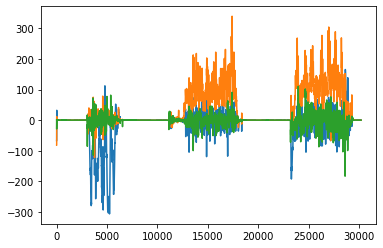

In [118]:
# Obtain Data from Gyroscope as Angular Velocity
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("data/data.csv")
gyro_x = np.array(df['gyro_x'].iloc[1:]).astype(float)
gyro_y = np.array(df['gyro_y'].iloc[1:]).astype(float)
gyro_z = np.array(df['gyro_z'].iloc[1:]).astype(float)
plt.plot(gyro_x)
plt.plot(gyro_y)
plt.plot(gyro_z)
gyro_x = gyro_x.reshape(gyro_x.shape[0],1)
gyro_y = gyro_y.reshape(gyro_y.shape[0],1)
gyro_z = gyro_z.reshape(gyro_z.shape[0],1)
angular_velocities = np.concatenate((gyro_x,gyro_y,gyro_z),axis=1)

In [120]:
# Integrate angular velocities to quaternions
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.animation as animation
from pytransform3d import rotations as pr
n_frames = 30000
dt = 0.01
start=0
Q = pr.quaternion_integrate(angular_velocities, q0=start, dt=1)

In [124]:
Q.shape

(30191, 4)

Automatically created module for IPython interactive environment


ValueError: Expected quaternion with shape (4,), got array-like object with shape ()

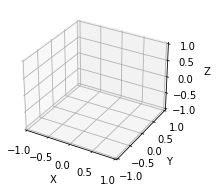

In [122]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.animation as animation
from pytransform3d import rotations as pr


def update_lines(step, Q, rot):
    R = pr.matrix_from_quaternion(Q[step])

    # Draw new frame
    rot[0].set_data(np.array([0, R[0, 0]]), [0, R[1, 0]])
    rot[0].set_3d_properties([0, R[2, 0]])

    rot[1].set_data(np.array([0, R[0, 1]]), [0, R[1, 1]])
    rot[1].set_3d_properties([0, R[2, 1]])

    rot[2].set_data(np.array([0, R[0, 2]]), [0, R[1, 2]])
    rot[2].set_3d_properties([0, R[2, 2]])

    return rot
fig = plt.figure(figsize=(4, 3))

ax = fig.add_subplot(111, projection="3d")
ax.set_xlim((-1, 1))
ax.set_ylim((-1, 1))
ax.set_zlim((-1, 1))
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

R = pr.matrix_from_quaternion(start)

rot = [
    ax.plot([0, 1], [0, 0], [0, 0], c="r", lw=3)[0],
    ax.plot([0, 0], [0, 1], [0, 0], c="g", lw=3)[0],
    ax.plot([0, 0], [0, 0], [0, 1], c="b", lw=3)[0],

    ax.plot([0, R[0, 0]], [0, R[1, 0]], [0, R[2, 0]],
            c="r", lw=3, alpha=0.3)[0],
    ax.plot([0, R[0, 1]], [0, R[1, 1]], [0, R[2, 1]],
            c="g", lw=3, alpha=0.3)[0],
    ax.plot([0, R[0, 2]], [0, R[1, 2]], [0, R[2, 2]],
            c="b", lw=3, alpha=0.3)[0]
]

anim = animation.FuncAnimation(fig, update_lines, n_frames,
                                fargs=(Q, rot),
                                interval=10, blit=False)

plt.show()


In [42]:

# Global Frame
G = np.array([
    [1,0,0],
    [0,1,0],
    [0,0,1]
])
# Watch Frame at t=0
W = np.array([
    [1,0,0],
    [0,1,0],
    [0,0,1]
])

In [45]:
from pytransform3d.rotations import (
    matrix_from_two_vectors, plot_basis, random_vector)
from pytransform3d.plot_utils import plot_vector

random_state = np.random.RandomState(1)
a = random_vector(random_state,3)
b = random_vector(random_state,3)

W = matrix_from_two_vectors(a,b)

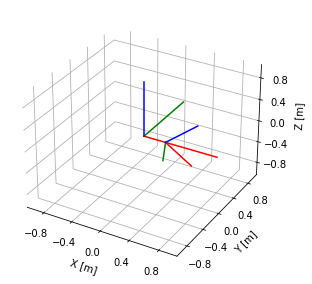

In [53]:
## Plot
import matplotlib.pyplot as plt
from pytransform3d.transformations import plot_transform
from pytransform3d.plot_utils import make_3d_axis
from pytransform3d.rotations import plot_basis

ax = make_3d_axis(ax_s=1, pos=111, unit="m", n_ticks=6)
plot_basis(ax=ax,R=G)
plot_basis(ax=ax,R=W,s=.5,p=[.3,0,0])
plt.tight_layout()
plt.show()